In [1]:
import sys
sys.path.insert(0, '../../')
from reinforce import Policy,REINFORCE
from utils.plot_chess import plot_game, plot_fen
import matplotlib.pyplot as plt
from build.chess_py import Game,Env
from utils.fen_parsing import parse_fen
import torch

2025-08-21 12:10:52,552 - INFO - Loading config file...


In [2]:
agent = REINFORCE()

In [6]:
fen = "8/1k6/8/8/3R4/4K3/8/8 w - - 0 1"
game = Game()
game.reset_from_fen(fen)

<Axes: >

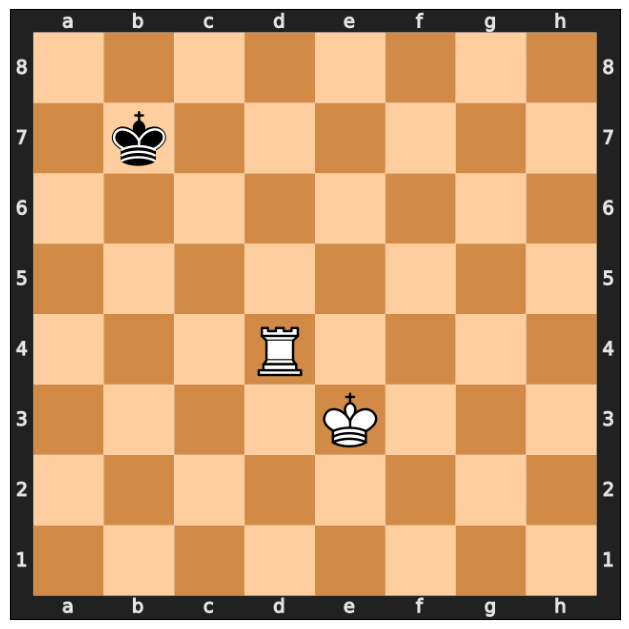

In [7]:
plot_game(game)

In [8]:
states, actions, rewards, players, DTM = agent.sample_episode(fen)

2025-08-21 12:12:23,000 - INFO - Position: 8/1k6/8/8/3R4/4K3/8/8 w - - 0 1
2025-08-21 12:12:23,000 - INFO - Step result done: True
2025-08-21 12:12:23,001 - INFO - Step result reward: -1.0
2025-08-21 12:12:23,001 - INFO - Legal moves for current side: 8
2025-08-21 12:12:23,002 - INFO - Game ended after 1 steps. Reward: -1.0


In [14]:
# Verify the episode data
print(f"Number of states: {len(states)}")
print(f"Number of actions: {len(actions)}")
print(f"Number of rewards: {len(rewards)}")
print(f"Number of players: {len(players)}")
print(f"DTM (Distance to Mate): {DTM}")
print(f"Total reward: {sum(rewards)}")
print(f"Players in episode: {players}")

Number of states: 1
Number of actions: 1
Number of rewards: 1
Number of players: 1
DTM (Distance to Mate): 1
Total reward: -1.0
Players in episode: [0]


In [7]:
actions

[1279]

In [8]:
agent.idx_to_move[actions[0]]

'e3d3'

In [318]:
agent.idx_to_move[actions[2]] 

'd7d5'

In [306]:
returns = agent.calculate_returns(rewards)

In [307]:
log_probs = []
episode_returns = []

for i, player in enumerate(players):
    if player == 0:  # White move (stored as 0 in our tracking)
        fen_tensor = parse_fen(states[i]).unsqueeze(0)
        legal_moves = agent.get_legal_move_indices_from_fen(states[i])  
        
        # Get log probabilities
        log_prob_dist = agent.policy.get_log_probs(fen_tensor, legal_moves)
        log_prob = log_prob_dist[0, actions[i]]
        
        log_probs.append(log_prob)
        episode_returns.append(returns[i])

In [308]:
log_probs_tensor = torch.stack(log_probs)
returns_tensor = torch.tensor(episode_returns, dtype=torch.float32)

In [309]:
log_probs_tensor

tensor([-3.0611, -3.0295], grad_fn=<StackBackward0>)

In [310]:
returns

[-0.9219999999999999, -0.96, -1.0]

In [311]:
loss = -torch.mean(log_probs_tensor * returns_tensor)
loss.item()

-2.9259190559387207

In [312]:
agent.optimizer.zero_grad()
loss.backward()
agent.optimizer.step()

In [313]:
DTM

2

In [111]:
log_prob_dist = agent.policy.get_log_probs(fen_tensor, legal_moves)
log_prob_dist[0, actions[0]]

tensor(-inf, grad_fn=<SelectBackward0>)

In [17]:
# Debug the get_log_probs issue
from utils.fen_parsing import parse_fen

# Get the first state from our episode
first_state = states[0]
print(f"First state FEN: {first_state}")

# Parse it to tensor
fen_tensor = parse_fen(first_state).unsqueeze(0)
print(f"FEN tensor shape: {fen_tensor.shape}")

# Get legal moves
legal_moves = agent.get_legal_move_indices_from_fen(first_state)
print(f"Legal moves: {legal_moves}")
print(f"Number of legal moves: {len(legal_moves)}")

# Check raw logits from the policy network
raw_logits = agent.policy.forward(fen_tensor)
print(f"Raw logits shape: {raw_logits.shape}")
print(f"Raw logits min: {raw_logits.min().item()}")
print(f"Raw logits max: {raw_logits.max().item()}")
print(f"Raw logits for legal moves: {[raw_logits[0, move].item() for move in legal_moves[:5]]}")

# Check what happens in get_log_probs
log_probs = agent.policy.get_log_probs(fen_tensor, legal_moves)
print(f"Log probs shape: {log_probs.shape}")
print(f"Log probs for legal moves: {[log_probs[0, move].item() for move in legal_moves[:5]]}")

First state FEN: 8/1k6/3R4/8/8/4K3/8/8 w - - 0 1
FEN tensor shape: torch.Size([1, 8, 8, 12])
Legal moves: [1271, 1272, 1273, 1279, 1280, 1286, 1287, 1288, 2712, 2720, 2728, 2736, 2744, 2749, 2750, 2751, 2752, 2753, 2754, 2755, 2759, 2767]
Number of legal moves: 22
Raw logits shape: torch.Size([1, 4096])
Raw logits min: -0.12721377611160278
Raw logits max: 0.13314536213874817
Raw logits for legal moves: [-0.00506611168384552, -0.017261162400245667, 0.010794637724757195, 0.009410848841071129, -0.05242393910884857]
Log probs shape: torch.Size([1, 4096])
Log probs for legal moves: [-3.074923038482666, -3.119713544845581, -3.082141637802124, -3.0707497596740723, -3.1320695877075195]


In [18]:
# Test the fixed get_log_probs                                                                                
agent = REINFORCE()  # Reload with the fix                                                  
# Test with the same FEN                                                                                      
log_probs_fixed = agent.policy.get_log_probs(fen_tensor, legal_moves)                                         
print(f"Fixed log probs for legal moves: {[log_probs_fixed[0, move].item() for move in legal_moves[:5]]}")    
print(f"Sum of probabilities for legal moves: {torch.exp(log_probs_fixed[0, legal_moves]).sum().item()}")    
# Should be close to 1.0 and log probs should be reasonable (not -inf)

Fixed log probs for legal moves: [-3.108431100845337, -3.0864436626434326, -3.0917508602142334, -3.080214023590088, -3.1528499126434326]
Sum of probabilities for legal moves: 0.9999999403953552
